# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [5]:
plt.rc('figure', figsize = (5,5))

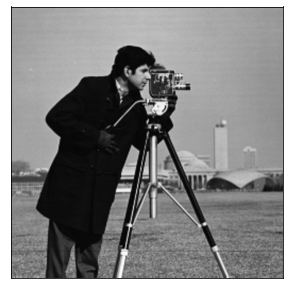

In [6]:
image = img_as_float(data.camera())
# Multi-channel example instead
# image = img_as_float(data.astronaut())
channels = 1
if image.ndim == 3:
    channels = image.shape[-1]
show(image)

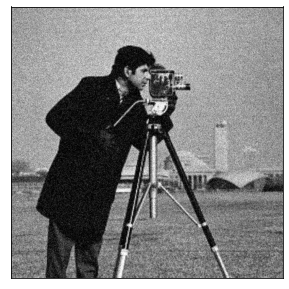

In [7]:
np.random.seed(3)
noisy_image = random_noise(image, mode = 'gaussian', var=0.01)
show(noisy_image)

In [8]:
import torch
if channels == 1:
    noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])
else:
    noisy_image = np.transpose(noisy_image)
    image = np.transpose(image)
    noisy = torch.Tensor(noisy_image[np.newaxis])

In [9]:
noisy.shape

torch.Size([1, 1, 512, 512])

In [10]:
from util import getbestgpu
device = getbestgpu()

GPU device 0 has 6072 MiB left.
--> GPU device 0 was chosen


In [11]:
device

0

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [12]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a deep convolutional network.

In [13]:
torch.manual_seed(3)
from models.dncnn import DnCNN
model = DnCNN(channels, num_of_layers = 8)

In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

223104

In [15]:
image.ravel().shape

(262144,)

# Training

In [16]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [17]:
model = model.to(device)
noisy = noisy.to(device)

In [18]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(500):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1), channels=channels)
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1, channels=channels)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if channels == 1:
                denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            else:
                denoised = np.clip(model(noisy).detach().cpu().numpy()[0], 0, 1).astype(np.float64)
            best_psnr = compare_psnr(denoised, image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 0.0303 	Val Loss: 	 0.01347
	Model PSNR:  6.85


<ipython-input-18-127425c0e1c7>:38: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  best_psnr = compare_psnr(denoised, image)


( 10 ) Loss: 	 0.0075 	Val Loss: 	 0.48986
( 20 ) Loss: 	 0.00261 	Val Loss: 	 0.03416
( 30 ) Loss: 	 0.00129 	Val Loss: 	 0.00171
	Model PSNR:  17.2
( 40 ) Loss: 	 0.00092 	Val Loss: 	 0.00121
	Model PSNR:  19.19
( 50 ) Loss: 	 0.0008 	Val Loss: 	 0.00074
	Model PSNR:  25.07
( 60 ) Loss: 	 0.00076 	Val Loss: 	 0.00073
	Model PSNR:  24.54
( 70 ) Loss: 	 0.0007 	Val Loss: 	 0.00074
( 80 ) Loss: 	 0.00068 	Val Loss: 	 0.00072
	Model PSNR:  25.72
( 90 ) Loss: 	 0.00071 	Val Loss: 	 0.00088
( 100 ) Loss: 	 0.00068 	Val Loss: 	 0.00075
( 110 ) Loss: 	 0.00067 	Val Loss: 	 0.00069
	Model PSNR:  26.36
( 120 ) Loss: 	 0.00069 	Val Loss: 	 0.00069
	Model PSNR:  26.36
( 130 ) Loss: 	 0.00068 	Val Loss: 	 0.00069
	Model PSNR:  26.18
( 140 ) Loss: 	 0.00066 	Val Loss: 	 0.00066
	Model PSNR:  27.46
( 150 ) Loss: 	 0.00068 	Val Loss: 	 0.00072
( 160 ) Loss: 	 0.00067 	Val Loss: 	 0.00072
( 170 ) Loss: 	 0.00066 	Val Loss: 	 0.00065
	Model PSNR:  27.57
( 180 ) Loss: 	 0.00066 	Val Loss: 	 0.00074
( 1

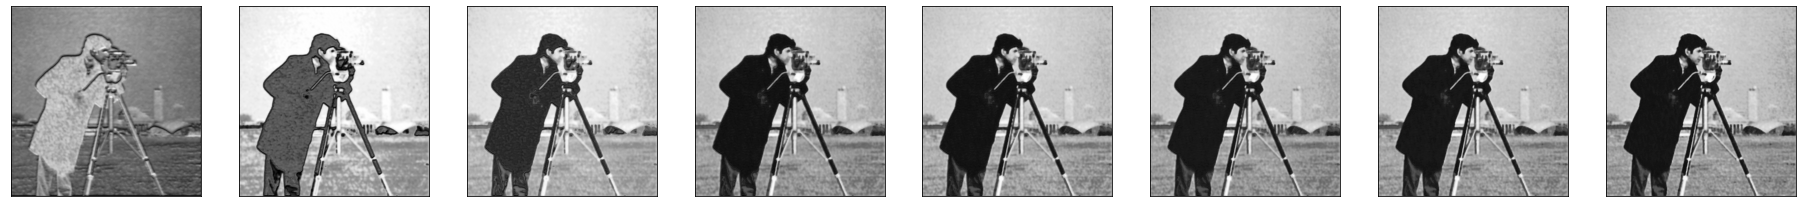

In [19]:
if channels == 1:
    # Not set up for multi-channel, yet
    plot_images(best_images[::2])

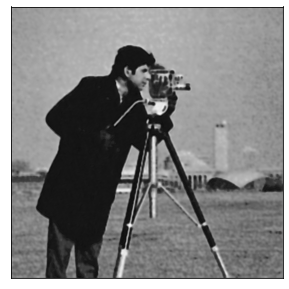

In [25]:
denoised = model(noisy).detach().cpu().numpy().astype(np.float64)
if channels != 1:
    denoised = denoised[0]
    show(denoised.transpose())
else:
    denoised = denoised[0,0]
    show(denoised)

In [21]:
np.max(denoised)

1.0126222372055054

In [22]:
denoised -= denoised.min()
denoised /= denoised.max()
compare_psnr(denoised, image)

<ipython-input-22-c2205af784d8>:3: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  compare_psnr(denoised, image)


28.67963860564151

In [23]:
inset_x_min = 100
inset_x_max = 160
inset_y_min = 230
inset_y_max = 290

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

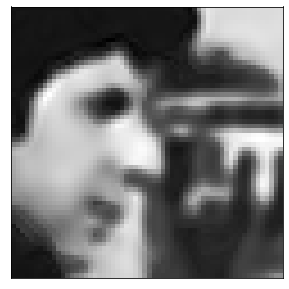

In [24]:
if channels == 1:
    show(get_inset(denoised))